In [10]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
import yfinance as yf

#import preprocessing 

In [11]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [12]:
# FOR REPRODUCIBILITY
np.random.seed(7)

tickerSymbol = 'MSFT'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
dataset = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25',)

dataset=dataset[["Open","High","Low","Close"]]
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = dataset.reindex(index = dataset.index[::-1])

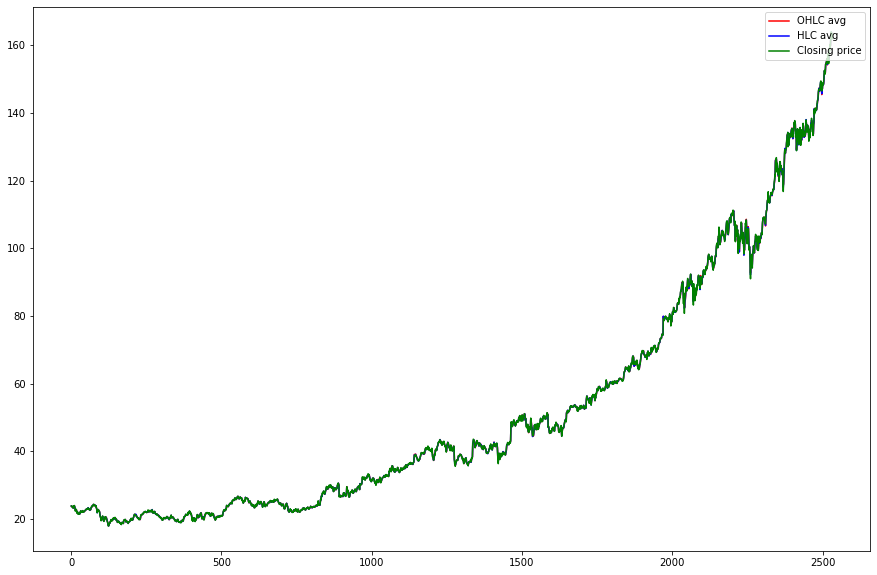

In [13]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(15, 10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [14]:
testScore_RMSE=np.zeros([5,1])
testScore_MAE=np.zeros([5,1])
testScore_r2=np.zeros([5,1])

# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]


for i in range (1,6):    

    step_size = i

    # TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
    trainX, trainY = new_dataset(train_OHLC, step_size)
    testX, testY = new_dataset(test_OHLC, step_size)

    # RESHAPING TRAIN AND TEST DATA
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # LSTM MODEL
    model = Sequential()
    model.add(Bidirectional(LSTM(64, input_shape=(1, step_size), return_sequences = True)))
    #model.add(LSTM(16))
    model.add(Dense(1))
    model.add(Activation("linear"))

    # MODEL COMPILING AND TRAINING
    model.compile(loss='mean_squared_error', optimizer='SGD') # Try SGD, adam, adagrad and compare!!!
    model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

    # PREDICTION
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict=trainPredict[:,:,0]
    testPredict=testPredict[:,:,0]

    # DE-NORMALIZING FOR PLOTTING
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # TEST RMSE
    testScore_RMSE[i-1] = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    testScore_MAE[i-1] = np.sum(abs(testY[0]-testPredict[:,0]))/np.shape(testY[0])
    testScore_r2[i-1]=r2_score(testY[0], testPredict[:,0])
    print('Test RMSE: %.2f' % (testScore_RMSE[i-1]))
    print('Test MAE: %.2f' % (testScore_MAE[i-1]))
    print('Test R2: %.2f' % (testScore_r2[i-1]))


Test RMSE: 1.39
Test MAE: 1.04
Test R2: 1.00
Test RMSE: 1.99
Test MAE: 1.50
Test R2: 0.99
Test RMSE: 2.21
Test MAE: 1.66
Test R2: 0.99
Test RMSE: 2.15
Test MAE: 1.61
Test R2: 0.99
Test RMSE: 2.72
Test MAE: 2.05
Test R2: 0.99


In [8]:
# TRAINING RMSE
trainScore_RMSE = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore_MAE = np.sum(abs(trainY[0]-trainPredict[:,0]))/np.shape(trainY[0])
print('Train RMSE: %.2f' % (trainScore_RMSE))
print('Train MAE: %.2f' % (trainScore_MAE))

# TEST RMSE
testScore_RMSE = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore_MAE = np.sum(abs(testY[0]-testPredict[:,0]))/np.shape(testY[0])
testScore_r2=r2_score(testY[0], testPredict[:,0])
print('Test RMSE: %.2f' % (testScore_RMSE))
print('Test MAE: %.2f' % (testScore_MAE))
print('Test R2: %.2f' % (testScore_r2))


# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

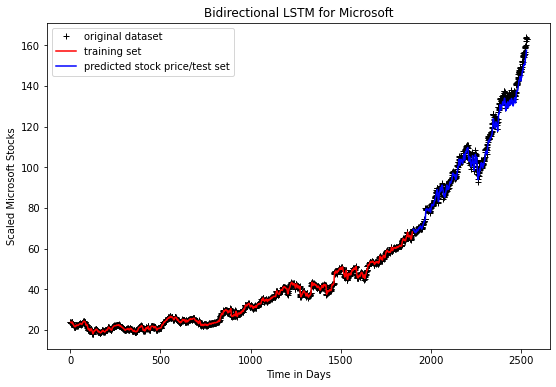

In [11]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(9, 6))
plt.plot(OHLC_avg, 'k+', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('Scaled Microsoft Stocks')
plt.title('Bidirectional LSTM for Microsoft')
plt.savefig('Microsoft_Bidirectional_LSTM_9x6.png')
plt.show()
#plt.savefig('TESLA_CNN_LSTM_6x6.png')